[View in Colaboratory](https://colab.research.google.com/github/3catz/time_series_LSTMS/blob/master/Time_Series_Forecasting_with_EMD_and_Fully_Convolutional_Neural_Networks_on_the_IRX_data_set.ipynb)

# TIME SERIES FORECASTING -- using Empirical Mode Decomposition with Fully Convolutional Networks for One-step ahead forecasting on the IRX time series. 


# Summary:# 
A noisy time series is additively decomposed into Intrinsic Mode Functions--oscillating, orthogonal basis functions, using the Empirical Mode Decomposition method pionered by Norden Huang. The IMF components are then used as features for a deep convolutional neural network, which can "learn" the decomposition--divide and conquer--and thereby improve forecasting performance and offer not only forecasting for the series but also the IMF components going into the future. This allows us to focus on forecasting physically significant or interesting IMFs. Note: This is additive, not multiplicative decomposition, which means that you consider the time series to be the sum of various components, rather than the product of various component functions. What it is--or rather, which is the better model--is something you have to explore. It helps to have domain knowledge, though more advanced forms of spectral analysis can also be used to glean insights in this regard. 

In this notebook, I demonstrate that using the IMFs a features alongside the original time series can do very well in out-of-sample forecasting, in this case, forecasting 1 step ahead. We used a lookback window of 10 lags from the signal as well as the IMFs to help us predict 1-step ahead in the future. Using the R2 coefficient of determination, we can see that the model can account for over 98% of the variation when applied to an out-of-sample forecast. 

# Data#

**IRX opening prices**
IRX is the stock ticker for the [13 Week Treasury Bill](https://finance.yahoo.com/quote/%5EIRX/history/).
I downloaded the data from [Comp-engine.org, a self-organizing database of time series](https://www.comp-engine.org/#!visualize/25c6285e-3872-11e8-8680-0242ac120002) fully accessible to the public.



# Architecture and Process#



1.   4 Conv layers, all from the original input, each with 128 hidden units, filter size of 3, dilation rates exponential powers of 2. 
2.   Concatenate these 4 layers with the original input--no adding or multiplying, just concatenate on axis = -1.
3.   Deconv with hidden units equal to number of IMF-components, in this case 11. 
4.   Add the predicted IMF-components together to reconstruct the signal, which is your yhat prediction for a step ahead.
5.   Compare with ground truth to see how you did. 



In [0]:
!pip install pyhht
!pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#import pandas_datareader.data as web
from pandas import Series
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer
import peakutils
#!pip install pyramid-arima
#from pyramid.arima import auto_arima

# Utilities: series to supervised

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [0]:
from google.colab import files    
files.upload()




In [0]:
import numpy as np  
data = np.fromfile("yourfilehere.dat", sep = "\n")
print(data)
len(data)


In [4]:
import numpy as np
data = np.genfromtxt("FLYahooop_IRX.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

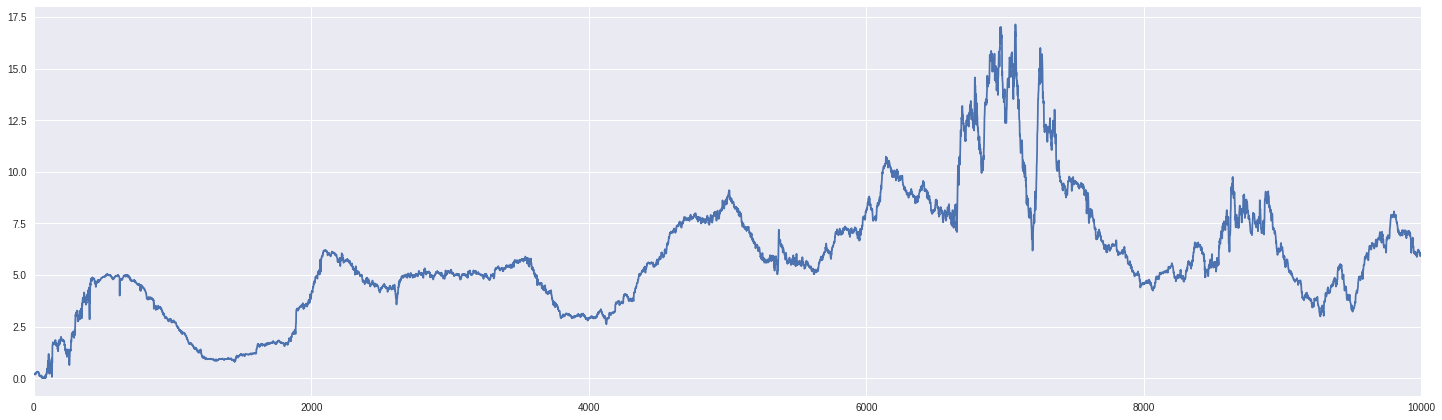

In [5]:
#Plot of Time Series
from scipy.interpolate import interp1d 
plt.figure(figsize=(20,6))
plt.plot(data)
plt.tight_layout()
plt.xlim([0,len(data)])
plt.show()

In [6]:
#Scale the Data to -1,1
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [0]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-1000]; out_sample = scaled_data[-1000:]

In [9]:
print(in_sample.shape)

(9000,)


#Empirical Mode Decomposition

From Yang et. al (2015), a summary: 
**Empirical mode decomposition (EMD)** technique to decompose the nonstationary signal into a series of intrinsic mode functions (IMFs) [9–11]. This ability makes HHT competitive in processing various composite signals [12–14]. With HHT, complex signals can be decomposed into multiple single-frequency signals that can further be processed by intrinsic mode function of EMD. *After the nonstationary signals have been decomposed into IMFs through EMD, these signals can easily be obtained by Hilbert transform of each mode function*. By doing so, researchers can obtain the instantaneous frequency and amplitude of each IMF. With the Hilbert spectrum and Hilbert marginal spectrum of IMFs, people can accurately get the joint distribution of energy with frequency and time and further predict whether IoT equipment is normal or not. Compared with FFT and VT, HHT is a strong adaptive time frequency analysis method.

In [10]:
from pyhht.emd import EMD 
from pyhht.visualization import plot_imfs

decomposer1 = EMD(in_sample,  maxiter = 10000)
imfs1 = decomposer1.decompose()
print("There are a total of %s IMFs" % len(imfs1))

There are a total of 11 IMFs


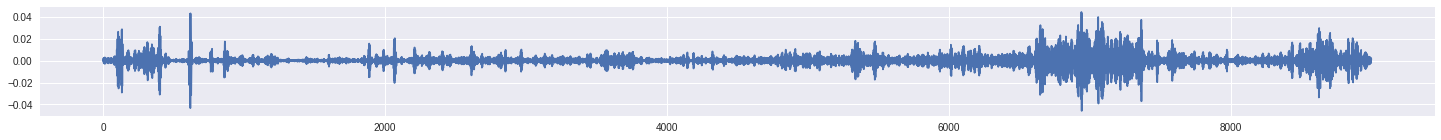

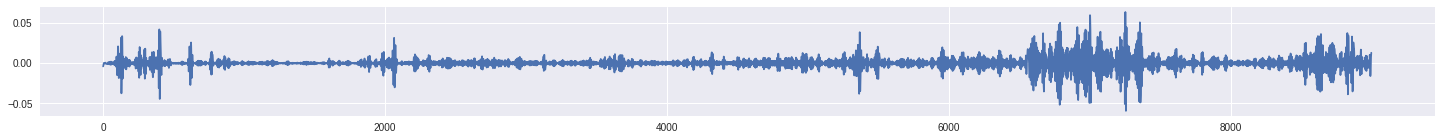

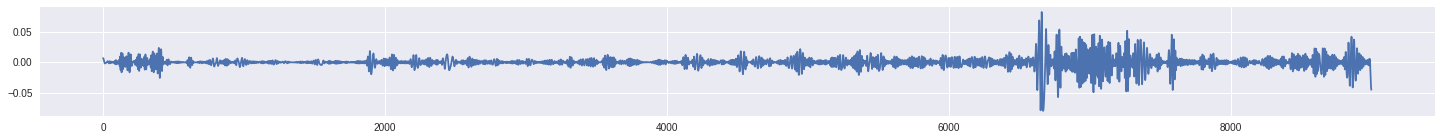

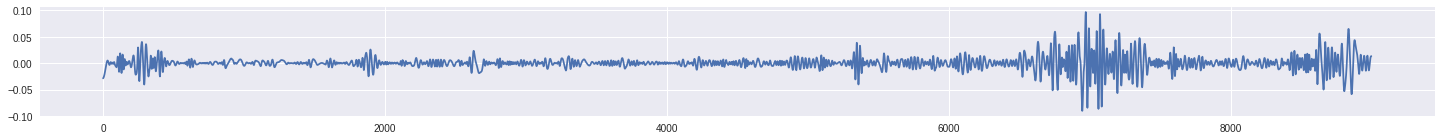

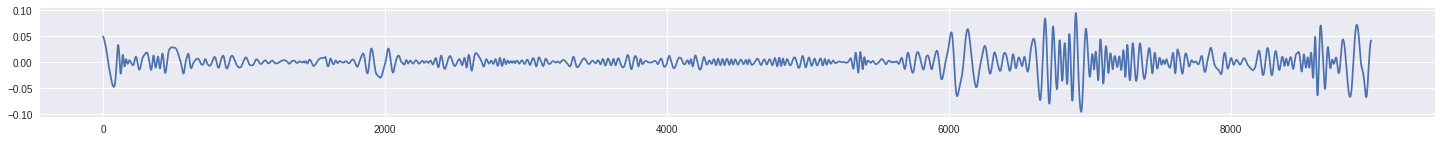

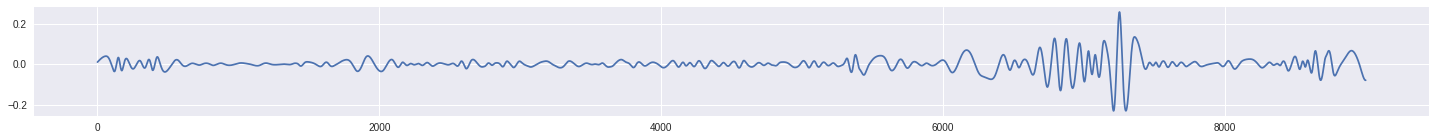

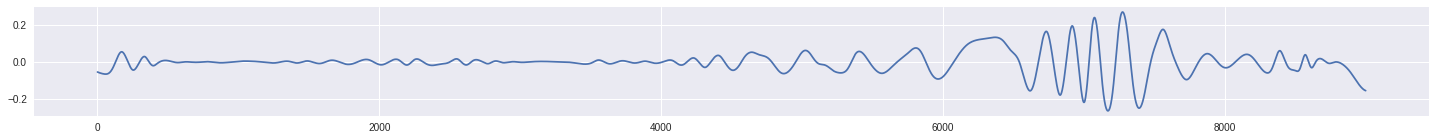

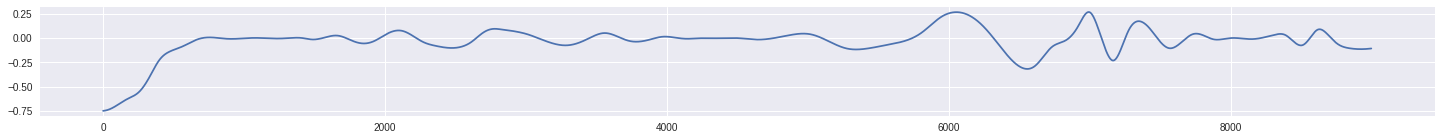

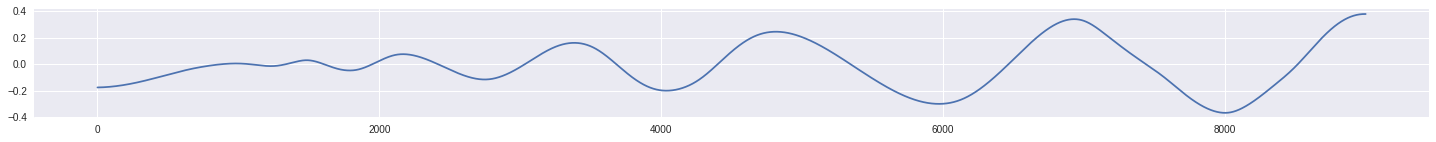

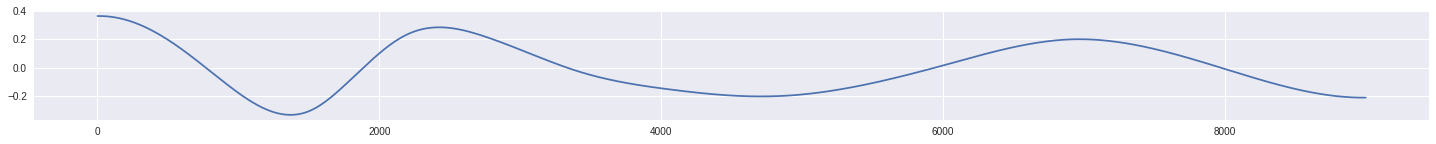

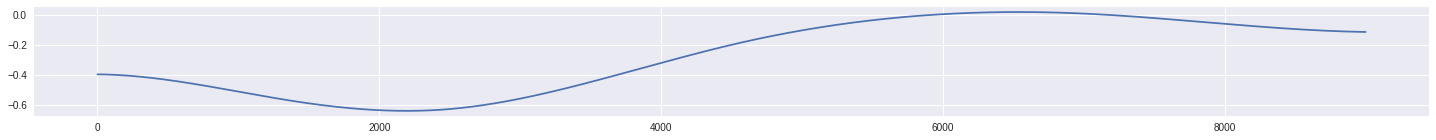

In [11]:
#Plot the IMFs, from highest frequency to lowest. The last one should be a monotonic trend function. It is known as the residue,
#the irreducible trend left after the detrending of the EMD process. 
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(25,2))
  fig = plt.plot(imfs1[i])
  plt.show()

In [0]:
import numpy as np
import pylab as plt
from scipy.signal import hilbert

#from PyEMD import EMD


def instant_phase(imfs):
    """Extract analytical signal through Hilbert Transform."""
    analytic_signal = hilbert(imfs)  # Apply Hilbert transform to each row
    phase = np.unwrap(np.angle(analytic_signal))  # Compute angle between img and real
    return phase

t = np.linspace(0,len(scaled_data),len(scaled_data))
dt = 1 
# Extract instantaneous phases and frequencies using Hilbert transform 
instant_phases = instant_phase(imfs1)
instant_freqs = np.diff(instant_phases)/(2*np.pi*dt)

# Create a figure consisting of 3 panels which from the top are the input signal, IMFs and instantaneous frequencies
fig, axes = plt.subplots(3, figsize=(20,18))

# The top panel shows the input signal
ax = axes[0]
ax.plot(t, scaled_data)
ax.set_ylabel("Amplitude [arb. u.]")
ax.set_title("Input signal Channel 1")

# The middle panel shows all IMFs
ax = axes[1]
for num, imf in enumerate(imfs1):
    ax.plot(t, imf, label='IMF %s' %(num+1))

# Label the figure
ax.legend()
ax.set_ylabel("Amplitude [arb. u.]")
ax.set_title("IMFs")

# The bottom panel shows all instantaneous frequencies
ax = axes[2]
for num, instant_freq in enumerate(instant_freqs):
    ax.plot(t[:-1], instant_freq, label='IMF %s'%(num+1))

# Label the figure
ax.legend()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Inst. Freq. [Hz]")
ax.set_title("Huang-Hilbert Transform")

plt.tight_layout()
plt.savefig('hht_example', dpi=120)
plt.show()


# Creating Datasets


*Raw Data, using a certian number of lags; most of my experimentation has beeen with either 10 or 20.

In [12]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(9000, 1)


In [0]:
lookback = 10
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [14]:

print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
Y = data_f[:,-1]
print(Xr.shape, Y.shape)

(8990, 11)
(8990, 10) (8990,)


# Use the IMFs--which are time series of equal length as the original signal, as features for convolutional/recurrent network.

In [15]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); imfs1.shape

(9000, 11)

In [16]:
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)

(8990, 1, 121)


In [17]:
imf_df = np.reshape(imf_df, (imf_df.shape[0], (lookback +1), imfs1.shape[-1]))

print(imf_df.shape)


(8990, 11, 11)


In [18]:
targets = imf_df[:,-1,:]
print(targets.shape)

(8990, 11)


In [19]:
print(Xr.shape) 

(8990, 10)


In [20]:
#so reshape everything properly
input_data = np.reshape(Xr, (targets.shape[0],1,lookback))
targets = np.reshape(targets,(targets.shape[0],1,targets.shape[1]))
print(input_data.shape, targets.shape)

(8990, 1, 10) (8990, 1, 11)


In [21]:
#test Y values--completely out of sample. The calculation of the IMFs
#was not influenced by these values. No information contamination from future to past.

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = lookback, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testY = out_df[:,-1]
testX = out_df[:,:-1]

testX = np.expand_dims(testX, axis = 1)
print(testX.shape,testY.shape)

(990, 11)
(990, 1, 10) (990,)


# Partial autocorrelation 

If you were doing SARIMA analysis, you would want to know if this series is autoregressive and to what extent. this helps when calculating a good lag for prediction, that is, how many past values you need to accurately predict a future value.

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


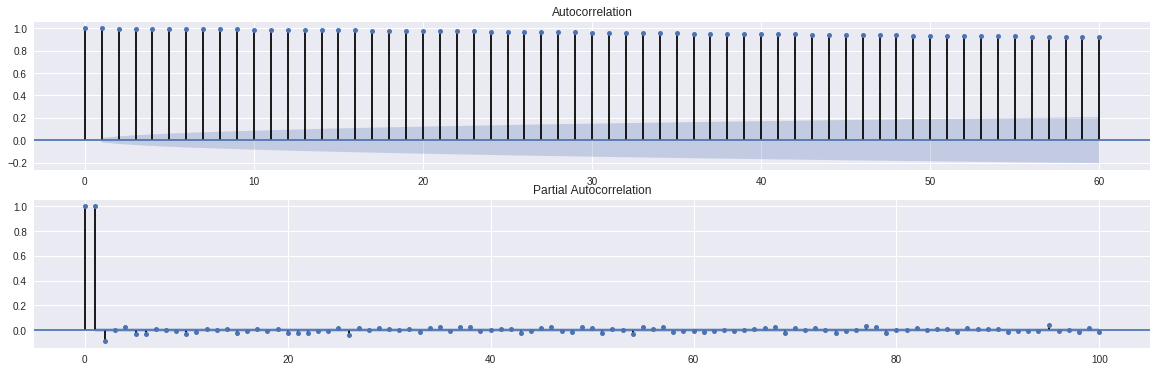

In [90]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

In [105]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import ConvLSTM2D
from keras.layers import LeakyReLU
np.random.seed(2018) #inputs are (1, 20) and outputs are #(1 time step,17 features)

def convs(x, n, f, rate, bn = False):
  x = Conv1D(n, f, padding = "causal", dilation_rate = rate, activation="tanh")(x)
  if bn == False:
    x = x 
  else:
    x = BatchNormalization()(x)
  return x   
  
  
inputs = Input(shape = (1, lookback))

x = convs(x = inputs, n = 128, f = 3, rate = 2, bn = False)
y = convs(x = inputs, n = 128, f = 3, rate = 4, bn = False)
u = convs(x = inputs, n = 128, f = 3, rate = 8, bn = False)
v = convs(x = inputs, n = 128, f = 3, rate = 16, bn = False)

z = concatenate([inputs, x, y, u, v], axis = -1)
z = Activation("tanh")(z)
z = Dropout(0.3)(z)

predictions = Conv1D(11, 3, padding = "causal", dilation_rate = 1)(z)
  


model = Model(inputs = inputs, outputs = predictions)
opt = adam(lr = 1e-3, clipnorm = 1.)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-4, patience = 10, verbose = 1)

model.compile(optimizer=opt, loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 20, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 1, 10)        0                                            
__________________________________________________________________________________________________
conv1d_134 (Conv1D)             (None, 1, 128)       3968        input_30[0][0]                   
__________________________________________________________________________________________________
conv1d_135 (Conv1D)             (None, 1, 128)       3968        input_30[0][0]                   
__________________________________________________________________________________________________
conv1d_136 (Conv1D)             (None, 1, 128)       3968        input_30[0][0]                   
__________________________________________________________________________________________________
conv1d_137

(990, 1)


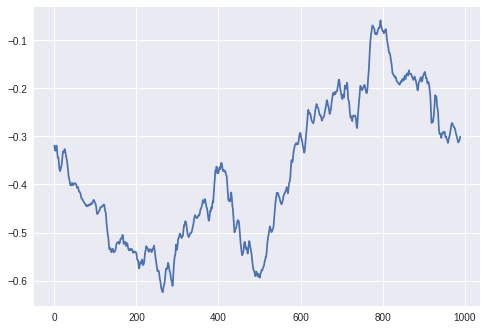

In [106]:
preds = model.predict(testX, batch_size = 1)
summed = np.sum(preds, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds)

# R2 analysis#
In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

It is a statistic used in the context of statistical models whose main purpose is either the prediction of future outcomes or the testing of hypotheses, on the basis of other related information. It provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model.[1][2][3]

Final R2 Score is: 0.9888552530780896


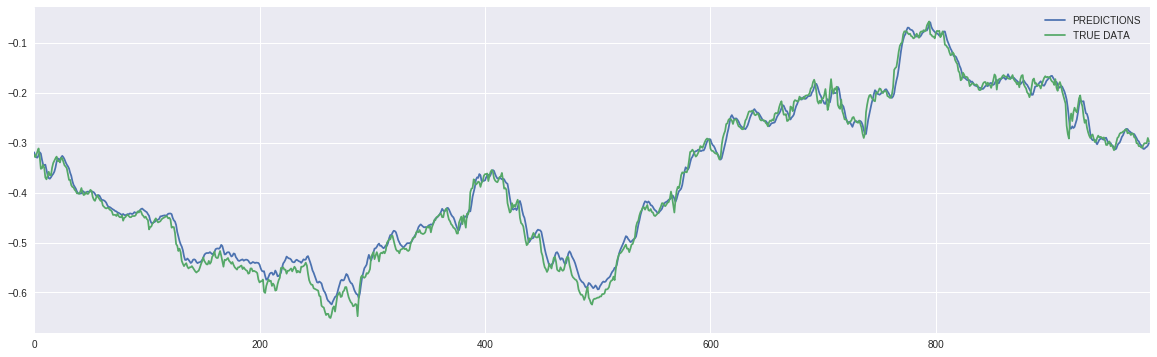

In [107]:
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))

fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0,990])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()